In [1]:
from data_processing import *

import matplotlib.pyplot as plt
import seaborn as sns

# Regression

In [2]:
def create_regression_dataset(dataset_name, col, dev_fraction, test_fraction, seed, raw_dataset_dir, output_dir, scale=None, bins=5, use_quantiles=True):
    """Creates a regression version of the dataset.
    
    It computes the train, dev, test split using the provided seed.
    It uses the provided scale to transform `col` and creates a `target`
    column with that value. It will round the `target` to an integer number.
    
    It creates `label` and equally spaced `bins` in the range [0, 100].
    We create 5 bins by default.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(output_dir)
    
    output_dir_stats = f"{output_dir}/statistics"
    os.makedirs(output_dir_stats, exist_ok=True)
    
    # ------------------------------------------------------
    # Step 1. Create the splits
    # ------------------------------------------------------
    # Train test split
    data = train_test_split(raw_dataset_dir, dataset_name, test_fraction, dev_fraction, seed)

    # Flatten the nested dictionary
    data = [flatten(d) for d in data]

    # Transform into dataframe to be more manageable and visual
    dfs = [pd.DataFrame(d).reset_index() for d in data]
    dfs_names = ["train", "dev", "test"]
    
    # ------------------------------------------------------
    # Step 2. Plot distributions
    # ------------------------------------------------------
    print("=" * 80)
    print(f"Train, dev, test set `{col}` distribution")
    plot_distributions(data=[d[col] for d in dfs], labels=dfs_names)
    
    if scale is not None:
        print("Scale!")
        def min_max_scale(df, min_r, max_r):
            df["target"] = df[col].apply(lambda e: (e-min_r)/(max_r-min_r))
            return df
        
        dfs = [min_max_scale(df, *scale) for df in dfs]
        plot_distributions(data=[d["target"] for d in dfs], labels=dfs_names)
    
    # Step 2.1. Plot *binary* distribution
    if use_quantiles:
        dist_fn = get_quantile_dists 
        kary_configs = {"q": bins, "precision": 2}
        
    else:
        def get_discrete(dfs, col, **configs):
            return [discretize_dist(d, col, **configs) for d in dfs]
        dist_fn = get_discrete
        kary_configs = {"binrange": (0, 100), "bins": bins}
        

    # Having the bins can be useful for sampling purposes in the end task
    print("-" * 80)
    print(f"{bins}-Class distribution using configs:", kary_configs)
    print("-" * 80)
    
    dfs_binned = dist_fn(dfs, "target", **kary_configs)
    plot_distributions(data=[d["label"] for d in dfs_binned], labels=dfs_names)

    for d, d_name in zip(dfs_binned, dfs_names):
        if len(d) != 0:
            d["target"] = d["target"].apply(round)
            d.describe().to_csv(f"{output_dir_stats}/{d_name}_statistics.csv", index_label="statistic")
            d.to_csv(f"{output_dir}/{d_name}.csv", index=False)

    all_dfs = pd.concat(dfs_binned)
    all_dfs.describe().to_csv(f"{output_dir_stats}/all_statistics.csv", index_label="statistic")        
    all_dfs.to_csv(f"{output_dir}/all.csv", index=False)
    return dfs

### RealSumm

../datasets/summ_data/REALSumm/quantile/regression
Loaded 100 examples.
Dataset REALSumm train-dev-test split: 40 30 30
Train, dev, test set `litepyramid_recall` distribution


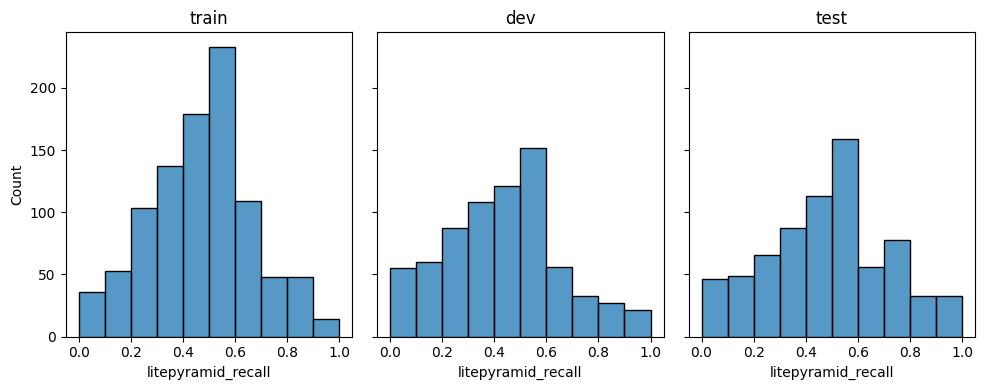

Scale!


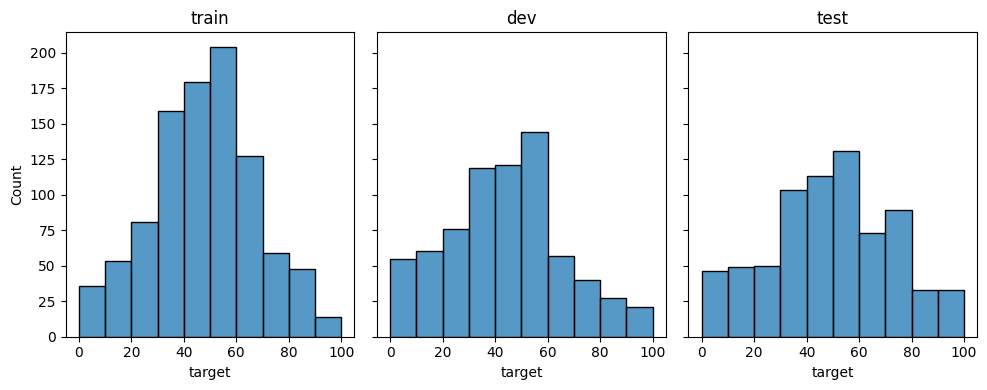

--------------------------------------------------------------------------------
5-Class distribution using configs: {'q': 5, 'precision': 2}
--------------------------------------------------------------------------------
woho
[  0.          30.61538462  42.85714286  50.          62.5
 100.        ]
[-1.00000000e-02  3.06153846e+01  4.28571429e+01  5.00000000e+01
  6.25000000e+01  1.00000000e+02]


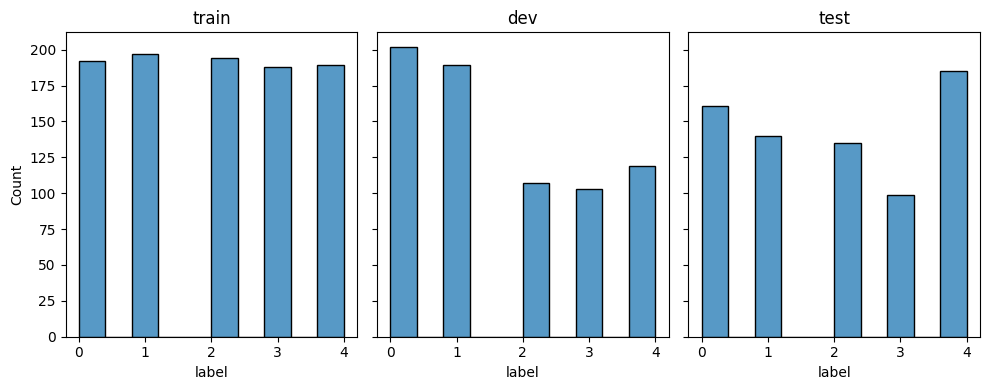

../datasets/summ_data/REALSumm/equal-sized-bins/regression
Loaded 100 examples.
Dataset REALSumm train-dev-test split: 40 30 30
Train, dev, test set `litepyramid_recall` distribution


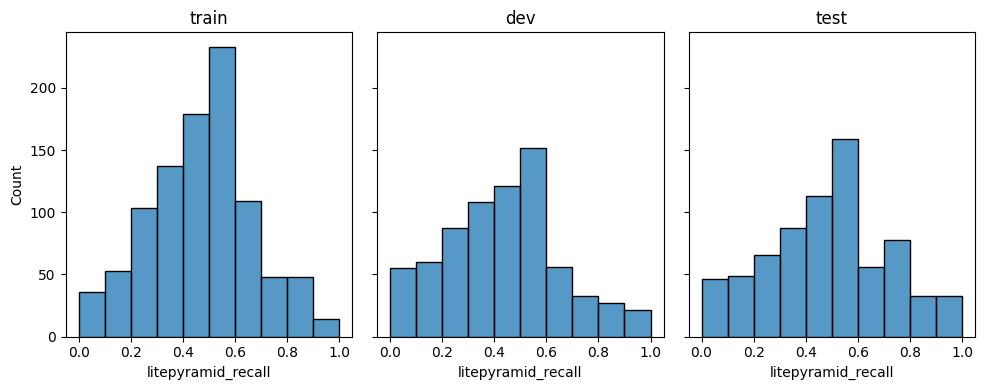

Scale!


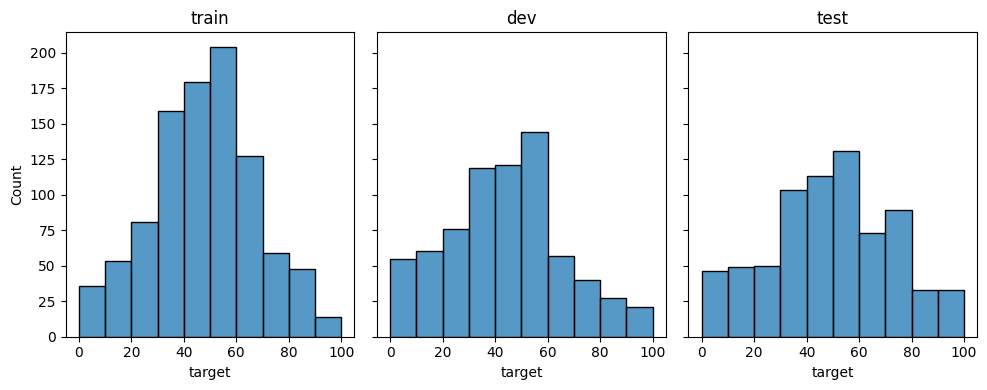

--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 100), 'bins': 5}
--------------------------------------------------------------------------------


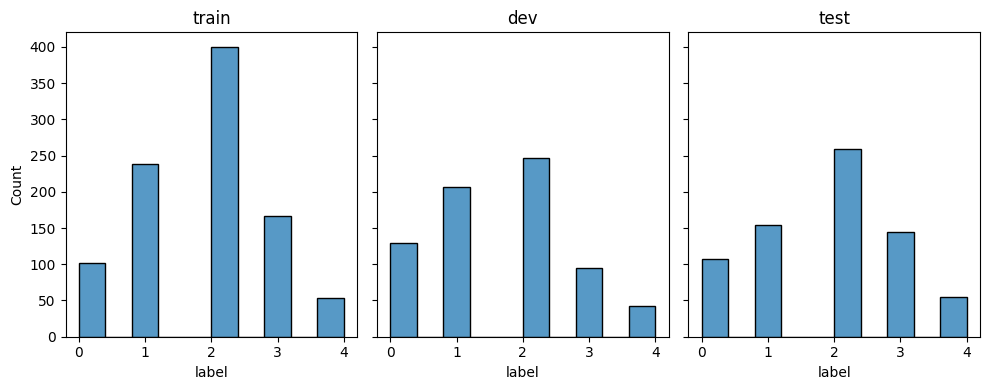

In [4]:
realsumm_metadata = {
    "dataset_name": "REALSumm",
    "col": "litepyramid_recall",
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "scale": (0, 0.01),
    "seed": 71563,
    "raw_dataset_dir": "../datasets/summ_data/",
    "output_dir": "../datasets/summ_data/REALSumm",
}

realsumm_outdir = realsumm_metadata.pop("output_dir")

# Create quantile-based distribution
train, dev, test = create_regression_dataset(**realsumm_metadata, use_quantiles=True, output_dir=f"{realsumm_outdir}/quantile/regression")

# Create equal-sized bin distribution
train, dev, test = create_regression_dataset(**realsumm_metadata, use_quantiles=False, output_dir=f"{realsumm_outdir}/equal-sized-bins/regression")